In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model


from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, silhouette_score

import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [5]:
DATA_PATH = '/Users/juliusraschke/Documents/Quantitative Finance/Summer Semester 2/Advanced Quant Finance/Data'

VIX_TS = pd.read_csv(DATA_PATH + '/VIX_TS_CUSTOM.csv')

VIX_TS = VIX_TS.rename({'Date':'DATE','VIX_1^2':'1 month','VIX_2^2':'2 month','VIX_3^2':'3 month','VIX_6^2':'6 month',
               'VIX_9^2':'9 month','VIX_12^2':'12 month'},axis=1)

### Data

In [6]:
x = VIX_TS.iloc[:,1:7]
Y = VIX_TS['DATE']

### Autoencoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, (input_dim*32))  # Example dimensions
        self.fc2 = nn.Linear((input_dim*32), (input_dim*16))
        self.fc3 = nn.Linear((input_dim*16), (input_dim*8))
        self.fc4 = nn.Linear((input_dim*8), (input_dim*4))
        self.fc5 = nn.Linear((input_dim*4), (input_dim*2))
        self.fc6 = nn.Linear((input_dim*2), latent_dim)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)  # No activation here, latent representation
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, (input_dim*2))
        self.fc2 = nn.Linear((input_dim*2), (input_dim*4))
        self.fc3 = nn.Linear((input_dim*4), (input_dim*8))
        self.fc4 = nn.Linear((input_dim*8), (input_dim*16))
        self.fc5 = nn.Linear((input_dim*16), (input_dim*32))
        self.fc6 = nn.Linear((input_dim*32), output_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.LeakyReLU(0.2)  # Add this line

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        z = self.relu(self.fc3(z))
        z = self.relu(self.fc4(z))
        z = self.relu(self.fc5(z))
        z = self.sigmoid(self.fc6(z))  # Sigmoid activation on final layer
        return z # Define the reconstruction loss function

In [8]:
# Define the reconstruction loss function
def reconstruction_loss(data, recon_data, MSE=True):
    if MSE:
        return nn.MSELoss()(data, recon_data)
    else:
        return nn.BCELoss()(data, recon_data)


In [9]:
# Define the training function
def train_PCA_AE(encoder, decoder, optimizer, epoch, train_loader, lambda_rec, code_size):
    encoder.train()
    decoder.train()
    
    train_loss = 0
    train_content_loss = 0

    for batch_idx, data_tuple in enumerate(train_loader):
        data = data_tuple[0]  # Extracting the data tensor
        
    
        # Encoding
        z = encoder(data)
        
        # Decoding
        recon_data = decoder(z)
        
        # Compute loss
        loss_data = lambda_rec * reconstruction_loss(recon_data, data, MSE=True)
        loss = loss_data
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_content_loss += loss_data.item()
      

In [10]:
Flag = True
lr = 0.001
scale_factor = 1

In [12]:
# Convert your training data to PyTorch tensors
X_train_tensor = torch.tensor(VIX_TS.iloc[:,1:].values, dtype=torch.float32)

# Define hyperparameters (unchanged)
num_epochs = 100
lambda_rec = 1.0

# Initialize encoder and decoder models
input_dim = X_train_tensor.shape[1]  # Number of features in your data
code_size = 6 # Latent space dimension

output_dim = input_dim  # Assuming the output dimension is same as input

encoder = Encoder(input_dim=input_dim, latent_dim=code_size)
decoder = Decoder(latent_dim=code_size, output_dim=output_dim)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=Flag)

# Define the optimizer (unchanged)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

# Training loop (unchanged)
for epoch in range(num_epochs):
    train_PCA_AE(encoder, decoder, optimizer, epoch, train_loader, lambda_rec, code_size)

In [13]:
# Ensure the encoder is in evaluation mode
encoder.eval()

# Assuming X_full_tensor is your entire dataset as a PyTorch tensor
X_full_tensor = torch.tensor(VIX_TS.iloc[:, 1:].values, dtype=torch.float32)

# Create a DataLoader for the entire dataset
full_dataset = TensorDataset(X_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=batch_size)  # Adjust batch_size as needed

# Process the entire dataset through the encoder only
encoded_data = []
with torch.no_grad():  # Disable gradient calculation for efficiency
    for data_tuple in full_loader:
        data = data_tuple[0]
        encoded = encoder(data)
        encoded_data.append(encoded)

# Convert the list of batches into a single tensor
encoded_data_tensor = torch.cat(encoded_data, dim=0)

# Convert the tensor to a NumPy array
encoded_data_np = encoded_data_tensor.numpy()

# Create a DataFrame from the NumPy array
encoded_data_df = pd.DataFrame(encoded_data_np, columns=['Level', 'Slope', 'Curve','AE 4','AE 5','AE 6'])

In [14]:
scaler = StandardScaler()
scaled = scaler.fit_transform(encoded_data_df)
scaled_dfx = pd.DataFrame(data=scaled)
scaled_dfx['Date']=VIX_TS['DATE']
scaled_dfx = scaled_dfx[['Date',0,1,2,3,4,5]]

In [15]:
scaled_AE = scaled_dfx[['Date',1]]

In [16]:
PCA = pd.read_csv(DATA_PATH + '/OUR_PCA.csv')
PCA = PCA.iloc[:,1:]

In [17]:
AE = scaled_dfx.iloc[:,1:]
column_mapping = {
    0: 'Level',
    1: 'Slope',
    2: 'Curve',
    3: 'PC4',
    4: 'PC5',
    5: 'PC6',
}
AE.rename(columns=column_mapping, inplace=True)

<ipython-input-17-028a3a648530>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AE.rename(columns=column_mapping, inplace=True)


In [18]:
correlation_matrix = PCA.corrwith(AE)

correlation_matrix

Level    0.986197
Slope    0.121832
Curve   -0.008626
PC4     -0.027765
PC5     -0.011670
PC6      0.014171
dtype: float64

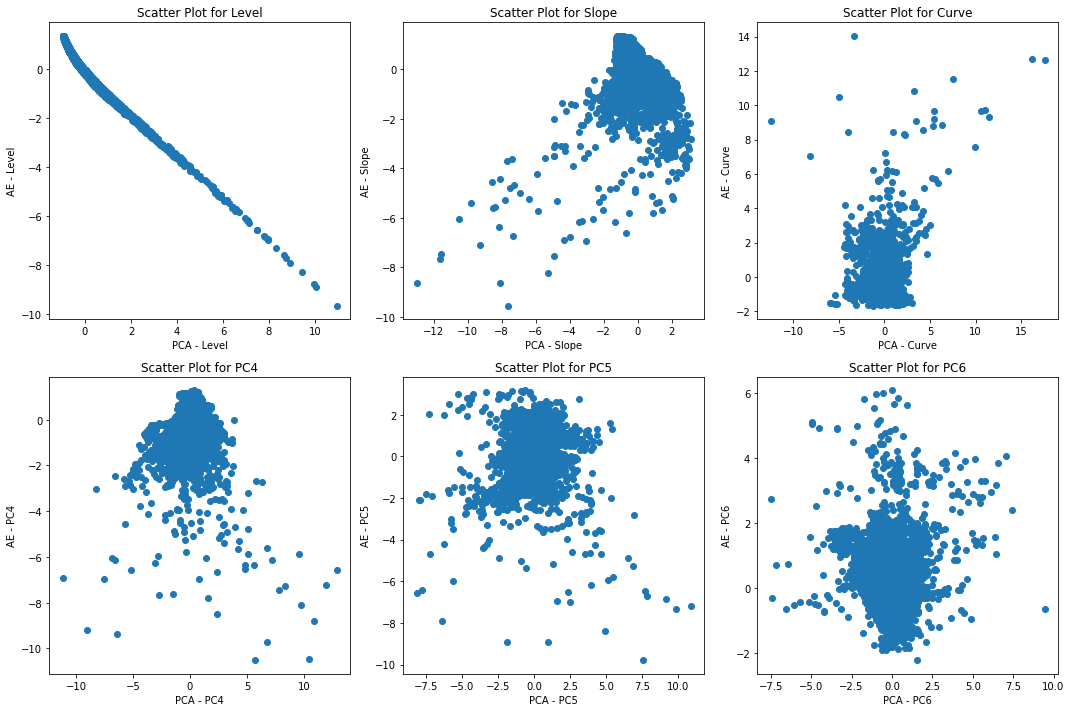

In [21]:
# Names of the variables
variables = ['Level', 'Slope', 'Curve', 'PC4', 'PC5', 'PC6']

# Create a figure with subplots
plt.figure(figsize=(15, 10)) # Adjust the size as needed

# Loop through each variable and create a subplot
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i) # 2 rows, 3 columns of subplots
    plt.scatter(PCA[var], -AE[var])
    plt.xlabel(f'PCA - {var}')
    plt.ylabel(f'AE - {var}')
    plt.title(f'Scatter Plot for {var}')

# Adjust layout for better viewing
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
scaled_AE.to_csv('/Users/juliusraschke/Documents/Quantitative Finance/Summer Semester 2/Advanced Quant Finance/Data/OUR_AE.csv')